# A Dynamic Discrete Choice Model with Harold Zurcher  in Rust (1987)
## Presented by Ha Pham
### AEM 7130 Spring 2023

# Introduction

- A popular model for dynamic decisions




- Widely applied in different fields including labor, IO,...

- Weakness: cannot be applied in dynamic games (mostly due to computational constraint)

# Overview
- Model Setups 
- Implementation in Julia
- Applications

# Model Background

- Harold Zurcher is responsible for changing bus engines for Madison Metro in Madison, WI


 



- Bus engines inherently get older, which makes them more costly to maintain. 

- Replacing the engine require an upfront fixed cost and "reset" the age

- This forms a dynamic trade-off: paying the fixed cost today for cheaper maintainance tomorrow or saving the fixed cost 

# Model Setup
- Time is discrete and infinite: $t = \{ 1,2,3,...,\infty\}$

- States are the discretized mileage of the engines: $s = \{0,5000-10000,10000-15000,...\} = \{0,1,2,3,...\}$ 

- Actions are discrete choices:  
\begin{cases}
        a_t = 1 &\text{if replace}  \\
        a_t = 0 &\text{if not replace} 
\end{cases}

- If $a_t = 1, s_{t+1} = 0$ with probability 1.  
- If $a_t = 0$, 
\begin{equation}
s_{t+1} =
\begin{cases}
     & s_t + 0 \text{ with probability } p\\
     & s_t + 1 \text{ with probability } q\\
     & s_t + 2 \text{ with probability } 1-p-q\\
\end{cases}
\end{equation}

- Given the current state and action, the state will evolve according to a Markovian transtition probability matrix. 
- The entries of the matrix are: $p(s_{t+1} = s' | s_t = s, a_t = a)$



# Model Timing 
1. States are observed 
2. Shocks are observed by the agent, econometrician knows the distribution
3. Choices are made (and observed) to maximize utility
4. States evolves according to the transition rule
5. Next period

# Period Payoff
Each period, the agent earns some profit based on the state and the action:

<center>$
\begin{equation}
\pi(s_t, a_t) = 
        -\theta*s - FC*a_t
\end{equation}
$</center>


In [2]:
function per_period_payoff(θ::Vector, i::Float64, s::Vector)::Vector
    """
    This function calculate the per period payoff given the state and action.

    Input:
    - θ: parameters in the cost function
    - i: action 
    - s: vector of states (mileage)

    Output:
    - a matrix of payoff
    """
    
    profit = (-θ[1]*0.001 .* s) .- θ[2] .* i 
    return profit
end

per_period_payoff (generic function with 1 method)

# Decision Problem
Each period, the action will maximize the expected utility. The strategy $a(.,.)$ will solve the problem:

<center>$ \max_{a_t} E_t \sum \beta^{t-1} [\pi(s_t, a_t) + \epsilon_{a}] $<center>
    
Define the value function:

<center>$ 
\begin{align}
V(x_t) &= \max_{a_t} \{ \pi(s_t, a_t) + \epsilon_{a} + \beta E[V(s_t)|s_t, a_t, \epsilon] \} \\
       &= \max_{a_t} \{ \pi(s_t, a_t) + \epsilon_{a} + \beta \int_S \int_\Omega V(s_t) p(s', \epsilon' | s,a,\epsilon) dx' d\epsilon'] \}
\end{align}
$<center>




# Assumptions
- conditional expectation
- logit errors


# Bellman Operator & Choice-specific Value Functions
- After some algebra, the following Bellman Operator is reached:

<center> $T(EV(s,a)) = \sum_S log(exp[ \pi(s',0) + \beta EV(s',0) ] + exp[ \pi(s',a) + \beta EV(s',a) ])p(s'|s,a)$ <center>
    
- Start with a guess of the value function (usual a vector of 0s) and apply value function iteration, the value function can be solved.

In [3]:
function compute_Vbar(θ::Vector, P::Matrix, β::Float64, 
                      tol::Float64, max_iter::Int64, print_flag::Bool)::Vector
    """ compute choice-specific value function by VFI
    Input: 
    - θ: vector of parameters in the payoff function
    - P: the transition probability matrix 
    - β: discounted value
    - tol: tolerance for VFI
    - max_iter: maximum iterations for VFI
    Output:
    - a vector of value function for each state (mileage)
    """

    # the state space 
    T = size(P)[1] # dimension
    x = collect(1:T) # as an array

    # initiate guess for the value function
    EV = zeros(T)

    # define the Bellman operator
    function bellman(EV)
        wait = per_period_payoff(θ, 0.0, x) .+ β*EV 
        x_replace = ones(Int64, T)
        replace = per_period_payoff(θ, 1.0, x_replace) .+ β*EV[1]
        M = max.(wait, replace)
        EV_new = M .+ log.(exp.(wait .- M) .+ exp.(replace .- M))
        EV_new = P * EV_new
        return EV_new
    end

    # find the fixed point of the Bellman operator
    error = 1000
    iter = 0
    
    while error > tol
        EV_new = bellman(EV)
        error = maximum(abs.(EV_new - EV))
        EV = EV_new
        iter += 1
        if iter > max_iter
            println("Value Function Iteration failed, took too long..")
            break
        end
    end

    # print output if print_flag is called
    if print_flag == true 
        if iter <= max_iter
            println("Value Function Iteration converged in $iter iterations.")
        end
    end

    # return the new EV
    return EV
end

compute_Vbar (generic function with 1 method)

# Maximum Likelihood Estimator
Use the choice-specific value function to get the conditional choice probability (CCP):

<center> $  
Prob(a_t | s_t; \theta) = \frac{exp(\pi(s,a) + \beta EV(s,a)}{exp(\pi(s,0) + \beta EV(s,0)) + exp(\pi(s,1) + \beta EV(s,1)}
$ <center>
    
Use the CCPs to get the log likelihood function:
    
<center> $
\mathcal{L} = \sum log(prob)
$<center

# Estimation Steps

Now that have learned how to solve the model, how can we estimate the parameters from observed data? 

In [4]:
using CSV 
using DataFrames
using Statistics
using LinearAlgebra
using Plots
using Optim
df = DataFrame(CSV.File("bus_data.csv"))
df.state = convert.(Int64, df.state)
df

Row,state,decision,next_state,change
,Int64,Float64,Float64?,Float64?
1,0,0.0,0.0,0.0
2,0,0.0,1.0,1.0
3,1,0.0,2.0,1.0
4,2,0.0,3.0,1.0
5,3,0.0,4.0,1.0
6,4,0.0,5.0,1.0
7,5,0.0,5.0,0.0
8,5,0.0,6.0,1.0
9,6,0.0,7.0,1.0


# Step 1: Estimate the state transition rule 
The state transition rule can be directly estimated by the empirical distribution from the data.

In [5]:
df = coalesce.(df, -1)
N = length(df.change[df.change .>= 0.0])
p = length(df.change[df.change .== 0.0]) / N
q = length(df.change[df.change .== 1.0]) / N
print("Estimated (p,q) is ($p, $q)")

Estimated (p,q) is (0.3500802370077768, 0.6383162572521911)

With the estimated probability $(p,q)$, we can generate the transition matrix:

In [6]:
function transition_matrix(T::Int64, p::Float64, q::Float64)::Matrix
"""
This function create a transitional probability matrix based on estimated parameters

Input:
- p & q: estimated transition probabilities
- T: dimension of state space

Output:
a TxT matrix
"""
    P = zeros(T,T)
    P += diagm(0 => ones(T) .* p) 
    P += diagm(1 => ones(T-1) .* q)
    P += diagm(2 => ones(T-2) .* (1-p-q))
    P[1:end, end] += 1 .- sum(P, dims=2)
return P
end

transition_matrix (generic function with 1 method)

In [1]:
# test it out
P = transition_matrix(90, p, q)
@code_warntype transition_matrix(90.0, p, q)


LoadError: UndefVarError: transition_matrix not defined

# Step 2: Compute Value Function given parameters (Inner Loop)

Value Function Iteration converged in 48244 iterations.


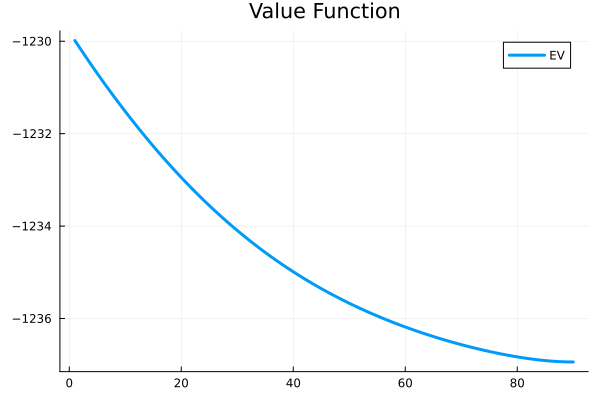

In [8]:
EV = compute_Vbar([2.0, 10.0], P, 0.9999, 1e-3, 300000, true)
x = 1:90
plot(x, EV, title="Value Function", label="EV", linewidth=3)

# Step 3: Searching for the parameters by ML (Outer Loop)

In [17]:
function conditional_probability(θ::Vector, P::Matrix, β::Float64, 
                                 tol::Float64, max_iter::Int64, print_flag::Bool)::Tuple
    """
    This function compute the conditional probability using the logit formula

    Input:
    - same as compute_Vbar()

    Ouput:
    - CCPs
    """
    
    # solve the model for the value function
    EV = compute_Vbar(θ, P, β, tol, max_iter, print_flag)
    
    # calculate the CCPs
    x = collect(1:90)
    T = 90
    wait = per_period_payoff(θ, 0.0, x) + β*EV
    x_replace = ones(Int64, T)
    replace = per_period_payoff(θ, 1.0, x_replace) .+ β*EV[1]
    P_wait = 1 ./ (1 .+ (exp.(replace .- wait)))
    P_replace = 1 .- P_wait

    return P_wait, P_replace
end

conditional_probability (generic function with 1 method)

In [22]:
function log_likelihood(θ::Vector, data::DataFrame, p::Float64, q::Float64,
    β::Float64, tol::Float64, max_iter::Int64, print_flag::Bool)::Float64
    """
    This function takes in the data and the guess of the parameters to go thru all the steps and calculate the log log_likelihood

    Input:
    - θ: parameters guesses  
    - data: pairs of (state, action)
    - (p,q): estimated transition conditional_probability
    - β, tol, max_iter, print_flag: same as in compute_Vbar

    Output:
    - Log likelihood to be maximized
    """
    if print_flag == true
        println("Current parameters are $θ")
    end

    # make the transition matrix
    P = transition_matrix(90, p, q)
    
    # Solve the inner loop to get the CCPs
    p_wait, p_replace = conditional_probability(θ, P, β, tol, max_iter, print_flag)
    
    # sum of all the log(prob) 
    log_likelihood = 0

    # this loop looks very bad because I don't really know how to work with df in Julia..
    for i in 1:size(df)[1]
        if df.decision[i] == 0.0
            log_likelihood += log(p_wait[df.state[i] + 1])
        elseif df.decision[i] == 1.0
            log_likelihood += log(p_replace[df.state[i] + 1])
        end
    end

    
    return -log_likelihood
end

log_likelihood (generic function with 1 method)

In [24]:
@time result = optimize(x -> log_likelihood(x, df, p, q, 0.9999, 1e-3, 300000, false), [1.0, 5.0])


 39.795127 seconds (44.46 M allocations: 30.593 GiB, 13.64% gc time, 0.10% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     2.961049e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   38  (vs limit Inf)
    Iterations:    38
    f(x) calls:    76


In [27]:
cost_parameter = result.minimizer[1]
replacement_cost = result.minimizer[2]
println("Successfully optimized! Cost parameter is $cost_parameter and replacement cost is $replacement_cost")

Successfully optimized! Cost parameter is 2.616121255861131 and replacement cost is 9.89488656672712


This is pretty close to groups 1,2,3,4 of table IX in Rust paper!

# Applications

- IO:
  - Investment Decision: Rust (1987), 
  - Innovation: Igami ()
 

- Energy & Environmental:
  - Eiseinberg ()
  - Cullen (2013)

- Labor:
  - Rust ...
  - ....

# Conclusion

- Rust (1987) provides an estimation routine that is still widely used today
- The model inspires many structural papers in different fields